In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [64]:
spark = SparkSession.builder.getOrCreate()

In [65]:
train = spark.read.option("inferSchema", "true").csv("BearTraining.csv", header = True)
train = train.select("Front Claws", "Pupillary Distance", "Ear Shape")
train = train.na.drop()
train = train.withColumn("Ear Shape", when(train["Ear Shape"]=="Pointed", 0).
                                  when(train["Ear Shape"]=="Broad", 1).otherwise(2))

cols = train.columns
train = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(train)

scaler = StandardScaler(inputCol="Vector", outputCol="features")
train = scaler.fit(train).transform(train)



train.show()



+-----------+------------------+---------+--------------+--------------------+
|Front Claws|Pupillary Distance|Ear Shape|        Vector|            features|
+-----------+------------------+---------+--------------+--------------------+
|        9.0|              12.0|        2|[9.0,12.0,2.0]|[3.64064500943049...|
|        9.6|              10.7|        1|[9.6,10.7,1.0]|[3.88335467672585...|
|        1.4|              15.1|        1|[1.4,15.1,1.0]|[0.56632255702252...|
|        5.4|              12.3|        1|[5.4,12.3,1.0]|[2.18438700565829...|
|        3.5|               9.0|        0| [3.5,9.0,0.0]|[1.41580639255630...|
|        2.6|               9.7|        0| [2.6,9.7,0.0]|[1.05174189161325...|
|        7.9|              16.3|        1|[7.9,16.3,1.0]|[3.19567728605565...|
|        4.6|              12.7|        1|[4.6,12.7,1.0]|[1.86077411593114...|
|        5.0|               9.2|        1| [5.0,9.2,1.0]|[2.02258056079471...|
|        3.8|              15.7|        2|[3.8,15.7,

In [66]:
test = spark.read.option("inferSchema", "true").csv("BearTesting.csv", header = True)

test = test.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")

test = test.na.drop()

test = test.withColumn("Ear Shape", when(test["Ear Shape"]=="Pointed", 0).
                                  when(test["Ear Shape"]=="Broad", 1).otherwise(2))

test = test.withColumn("Grizzly", when(test["Grizzly"]=="Yes", 1).otherwise(0))


cols = test.columns
cols.remove("Grizzly")

test = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(test)

scaler = StandardScaler(inputCol="Vector", outputCol="features")
test = scaler.fit(test).transform(test)



test.show()


+-----------+------------------+---------+-------+--------------+--------------------+
|Front Claws|Pupillary Distance|Ear Shape|Grizzly|        Vector|            features|
+-----------+------------------+---------+-------+--------------+--------------------+
|        3.7|              11.3|        2|      0|[3.7,11.3,2.0]|[1.49191519757039...|
|        7.8|              12.0|        2|      1|[7.8,12.0,2.0]|[3.14511852460785...|
|        5.1|              11.1|        1|      1|[5.1,11.1,1.0]|[2.05642365070513...|
|        9.1|              11.8|        0|      0|[9.1,11.8,0.0]|[3.66930494537583...|
|        4.6|              12.4|        1|      0|[4.6,12.4,1.0]|[1.85481348887129...|
|        2.9|              10.4|        1|      0|[2.9,10.4,1.0]|[1.16933893863625...|
|        4.9|              11.3|        1|      0|[4.9,11.3,1.0]|[1.97577958597160...|
|        3.1|              10.7|        1|      0|[3.1,10.7,1.0]|[1.24998300336978...|
|        1.7|               9.4|        2| 

In [67]:
kmeans = KMeans().setK(2)
model = kmeans.fit(train)

In [68]:
prediction = model.transform(test)
prediction.show()

+-----------+------------------+---------+-------+--------------+--------------------+----------+
|Front Claws|Pupillary Distance|Ear Shape|Grizzly|        Vector|            features|prediction|
+-----------+------------------+---------+-------+--------------+--------------------+----------+
|        3.7|              11.3|        2|      0|[3.7,11.3,2.0]|[1.49191519757039...|         1|
|        7.8|              12.0|        2|      1|[7.8,12.0,2.0]|[3.14511852460785...|         1|
|        5.1|              11.1|        1|      1|[5.1,11.1,1.0]|[2.05642365070513...|         0|
|        9.1|              11.8|        0|      0|[9.1,11.8,0.0]|[3.66930494537583...|         1|
|        4.6|              12.4|        1|      0|[4.6,12.4,1.0]|[1.85481348887129...|         0|
|        2.9|              10.4|        1|      0|[2.9,10.4,1.0]|[1.16933893863625...|         0|
|        4.9|              11.3|        1|      0|[4.9,11.3,1.0]|[1.97577958597160...|         0|
|        3.1|       

In [69]:
prediction = prediction.toPandas()

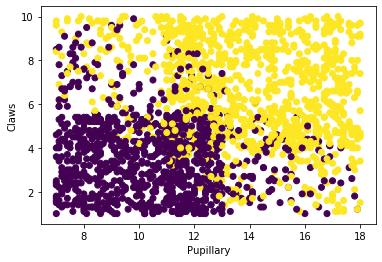

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(prediction["Pupillary Distance"],prediction["Front Claws"], c=prediction["prediction"])
ax.set_xlabel("Pupillary")
ax.set_ylabel("Claws")
plt.show()

In [71]:
count = 0
for index, row in prediction.iterrows():
    if row["Grizzly"] == row["prediction"]:
        count +=1
        
print("Accuracy: {}%".format(count / len(prediction) * 100))

Accuracy: 83.55%
